# Microsoft Movie Studio Exploratory Analysis
- By: Sabina Bains
- 10/13/2021
- Self-Paced
- Scheduled project review date / time: Friday, 10/13/21
- Instructor name: Claude Fried

## Objective:

Explore historical movie data to determine types of movies that are most successful at the box office for Microsoft’s studio to utilize. This exploratory analysis dives into the following topics:
- Genre Analysis
- Crew Analysis
- Monthly Trends

Data used:
- The Numbers (https://www.the-numbers.com/)
- IMDB (https://www.imdb.com)


### Importing Packages and Reading in Files

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import statistics
import os

# Setting options and styles
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-talk')

In [2]:
#Viewing filenames for easier file importing
filenames = os.listdir('zippeddata')
paths = []

for file in filenames:
    paths.append('zippeddata/'+file)
    
for num, name in enumerate(paths):
    print(num, name)

0 zippeddata/imdb.title.crew.csv.gz
1 zippeddata/tmdb.movies.csv.gz
2 zippeddata/imdb.title.akas.csv.gz
3 zippeddata/imdb.title.ratings.csv.gz
4 zippeddata/imdb.name.basics.csv.gz
5 zippeddata/rt.reviews.tsv.gz
6 zippeddata/imdb.title.basics.csv.gz
7 zippeddata/rt.movie_info.tsv.gz
8 zippeddata/tn.movie_budgets.csv.gz
9 zippeddata/bom.movie_gross.csv.gz
10 zippeddata/imdb.title.principals.csv.gz


#  GENRE ANALYSIS: TOP GENRES BY MEDIAN PROFIT AND BUDGET

In [3]:
# importing box office data
profit = pd.read_csv(paths[8])

In [4]:
# Importing Genre + movie title Data
genres = pd.read_csv(paths[6])

In [5]:
# creating a new column "start_year" based on the year of the release date for merging with the sales data.
profit['start_year'] = profit['release_date'].map(lambda x : x[-4:])
profit.rename(columns={'movie':'primary_title'}, inplace=True)
genres['start_year']=genres['start_year'].astype(str)

In [6]:
# merging on movie title and year release 
f = pd.merge(genres,profit,on=['primary_title','start_year'],how='inner')

In [7]:
# dropping NA's
f = f.dropna()

In [8]:
# Removing "," and "$" from dollar columns to turn into type int
f_dollar_cols = ['production_budget', 'domestic_gross','worldwide_gross']
for i in f_dollar_cols:
    f[i]=f[i].str.replace('$','')
    f[i]=f[i].str.replace(',','').astype(int)
f['profit']=f['worldwide_gross']-f['production_budget']

In [9]:
# creating values in Millions for nicer looking analysis
def in_MM(df,new_col,col):
    df[new_col] = df[col]/1000000
    
in_MM(f,'Budget (MM)','production_budget')
in_MM(f,'Profit (MM)','profit')
in_MM(f,'Gross (MM)','worldwide_gross')

In [10]:
#Creating Deduplicated list of Genres to use as Keys for Dictionary
genre_list = f.genres.str.split(',').to_list()
genre_list = list(set(list(chain.from_iterable(genre_list))))

In [11]:
#creating dictionary with values as lists to map ratings to genres
genre_dict={}
for item in genre_list:
    genre_dict[item] = []
    
val_dict={}
for item in genre_list:
    val_dict[item] = []

In [12]:
#appending values from df to dictionary based on genre key
for index, row in f.iterrows():
    for genre in val_dict:
        if genre in row['genres']:
            val_dict[genre].append(row['Profit (MM)'])

In [13]:
budget_dict= genre_dict.copy()
for index, row in f.iterrows():
    for genre in budget_dict:
        if genre in row['genres']:
            budget_dict[genre].append(row['Budget (MM)'])

In [14]:
# calculating count of movies in each genre (so we can exclude genres with low movie sample)
count_dict = genre_dict.copy()
for i in count_dict:
    count_dict[i] = len(count_dict[i])

In [15]:
# calculating average rating per Genre
median_val_dict = {}
for i in val_dict:
    median_val_dict[i] = statistics.median(val_dict[i])

In [16]:
# calculating average rating per Genre
budget_val_dict = {}
for i in budget_dict:
    budget_val_dict[i] = statistics.median(budget_dict[i])

In [17]:
#creating df from ratings column from dictionary
profit_by_genre = pd.DataFrame(median_val_dict,index=['Median Profit (MM)'])
profit_by_genre = profit_by_genre.transpose()
profit_by_genre = profit_by_genre.reset_index()

In [18]:
budget_by_genre = pd.DataFrame(budget_val_dict,index=['Median Budget (MM)'])
budget_by_genre = budget_by_genre.transpose()
budget_by_genre = budget_by_genre.reset_index()

In [19]:
#creating df with count column from dictionary
count_by_genre = pd.DataFrame(count_dict,index=['Count'])
count_by_genre = count_by_genre.transpose()
count_by_genre = count_by_genre.reset_index()

In [20]:
# final merge onto genre column for analysis
genre = pd.merge(profit_by_genre, budget_by_genre, on="index")
genre = pd.merge(genre, count_by_genre, on="index")
genre.rename(columns={'index':'Genre'},inplace=True)

In [21]:
# filtering out any genre column that has less than 10 movies represented and sorting by highest rating
genre = genre.loc[genre['Count'] >= 10].reset_index(drop=True)
genre = genre.sort_values('Median Profit (MM)', ascending = False)

In [22]:
#no longer need count column
genre = genre.drop(columns='Count')

In [23]:
# keeping only top 10 genres for bar plot
genre = genre.head(10)

In [24]:
# stacking data for input in barplot 
genre = genre.melt(id_vars='Genre').rename(columns=str.title)

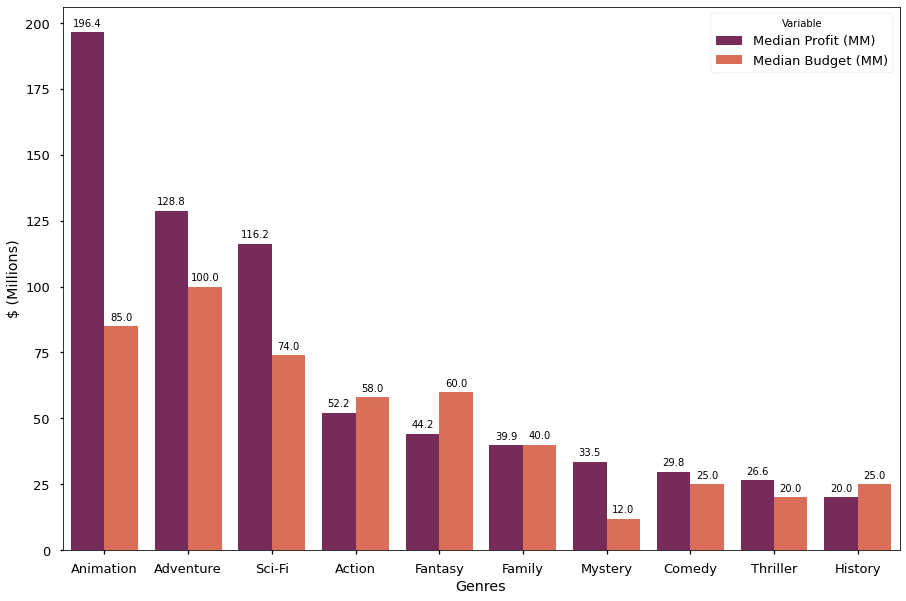

In [25]:
#creating barplot of median profit and budget by genre
fig, ax = plt.subplots(figsize=(15, 10))

barplot = sns.barplot(x='Genre', y='Value', hue='Variable', data=genre, palette="rocket", ax=ax)
ax.set(xlabel='Genres', ylabel='$ (Millions)')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

In [26]:
# creating function to get more info on the top 5 films in each genre 
def top_in_genre(genre):
    cols=['primary_title', 'release_date',
       'runtime_minutes','genres',
       'production_budget','worldwide_gross', 'profit']
    df = f[cols]
    df = df.loc[df['genres'].str.contains(genre)]
    df = df.sort_values(by='profit',ascending=False).head(5)
    return df

In [27]:
# taking a look at each genre 
top_in_genre('Adventure')

,primary_title,release_date,runtime_minutes,genres,production_budget,worldwide_gross,profit
1336,Avengers: Infinity War,"Apr 27, 2018",149.0,"Action,Adventure,Sci-Fi",300000000,2048134200,1748134200
3,Jurassic World,"Jun 12, 2015",124.0,"Action,Adventure,Sci-Fi",215000000,1648854864,1433854864
82,The Avengers,"May 4, 2012",143.0,"Action,Adventure,Sci-Fi",225000000,1517935897,1292935897
731,Black Panther,"Feb 16, 2018",134.0,"Action,Adventure,Sci-Fi",200000000,1348258224,1148258224
1420,Jurassic World: Fallen Kingdom,"Jun 22, 2018",128.0,"Action,Adventure,Sci-Fi",170000000,1305772799,1135772799


# SUGGESTION 2 

#don't need the region when merging with profit since they are all US, can skip the beginning merge

In [28]:
#read in data, merge together
namebasics = pd.read_csv(paths[4])
titleps = pd.read_csv(paths[10])
crew = pd.merge(titleps,namebasics,on='nconst',how='left')

#merge with financial data
fcrew = pd.merge(crew,f,on='tconst',how='inner')

In [29]:
in_MM(fcrew,'Budget (MM)','production_budget')
in_MM(fcrew,'Profit (MM)','profit')
in_MM(fcrew,'Gross (MM)','worldwide_gross')

fcrew['Profit (B)'] = fcrew['Profit (MM)']/1000

In [30]:
#keep certain cols
crew_cols = ['category','tconst','primary_name','characters','primary_title','genres','release_date',
            'Budget (MM)','Gross (MM)','Profit (MM)','Profit (B)']
fcrew = fcrew[crew_cols]

In [31]:
fcrew['category'].unique()

array(['cinematographer', 'actor', 'director', 'producer', 'composer',
       'actress', 'writer', 'editor', 'production_designer', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

In [32]:
#filter on genres based on last suggestion
animation = fcrew.loc[fcrew['genres'].str.contains('Animation')]
action = fcrew.loc[fcrew['genres'].str.contains('Adventure')]
comedy = fcrew.loc[fcrew['genres'].str.contains('Comedy')]

# fcrew = pd.concat(animation,action,comedy)
fcrew = animation.append([action, comedy])

In [33]:
def top_crew(df,category_list,chart_title):
    df = df.loc[df['category'].isin(category_list)] 
    df = df.groupby('primary_name')['Profit (B)'].agg(['sum','count']).reset_index()
    df.sort_values('sum',ascending=False,inplace=True)
    df = df.drop_duplicates()
    
    sns.set_style(style='white') 
    fig, ax = plt.subplots(figsize=(15,10))
    sns.barplot(x = 'primary_name',
                y = 'sum',
                data = df.head(3),
                palette="rocket",
                ax = ax)
    ax.set(xlabel='', ylabel='Profit Sum (Billions)')
    plt.title(chart_title, size=22)
    sns.set(font_scale = 2)
    fig.tight_layout()
    return fig, df.head(3)

(<Figure size 1080x720 with 1 Axes>,
     primary_name        sum  count
 994     Stan Lee  10.851624     18
 195   Cinco Paul   9.337987     14
 636   Ken Daurio   9.337987     14)

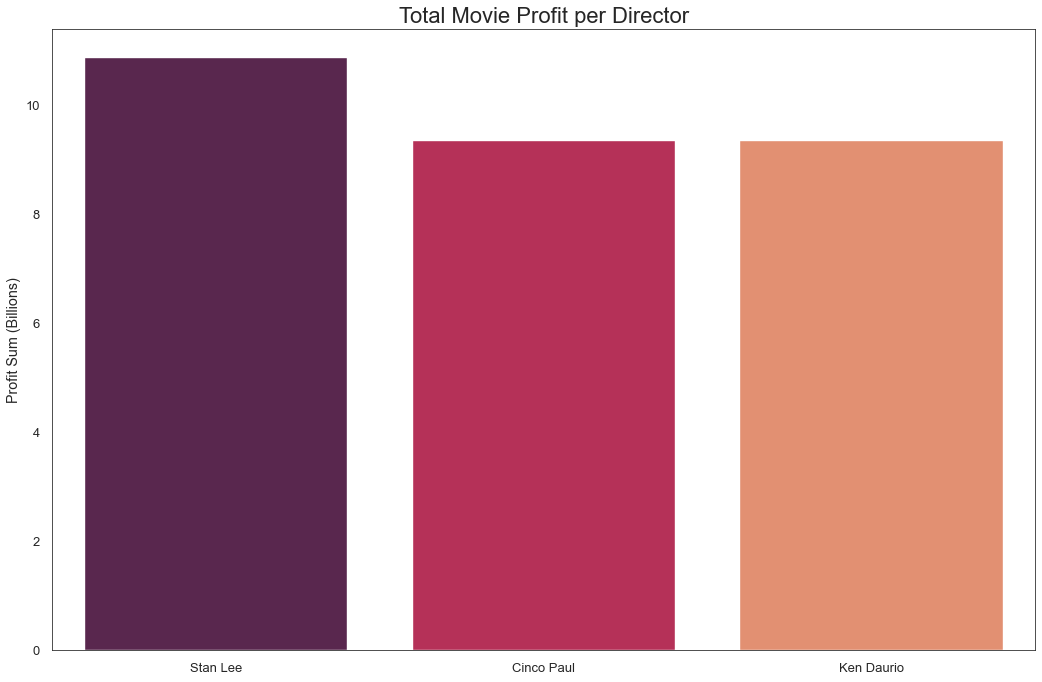

In [34]:
top_crew(fcrew,['writer'],'Total Movie Profit per Director')

In [35]:
fcrew.loc[fcrew['primary_name']=='Michael Giacchino'].drop_duplicates()

,category,tconst,primary_name,characters,primary_title,genres,release_date,Budget (MM),Gross (MM),Profit (MM),Profit (B)
5130,composer,tt1216475,Michael Giacchino,NaN,Cars 2,"Adventure,Animation,Comedy","Jun 24, 2011",200.0,560.155383,360.155383,0.360155
9571,composer,tt2380307,Michael Giacchino,NaN,Coco,"Adventure,Animation,Comedy","Nov 22, 2017",175.0,798.008101,623.008101,0.623008
10705,composer,tt3606756,Michael Giacchino,NaN,Incredibles 2,"Action,Adventure,Animation","Jun 15, 2018",200.0,1242.520711,1042.520711,1.042521
2985,composer,tt1617661,Michael Giacchino,NaN,Jupiter Ascending,"Action,Adventure,Sci-Fi","Feb 6, 2015",179.0,181.982519,2.982519,0.002983
3136,composer,tt1964418,Michael Giacchino,NaN,Tomorrowland,"Action,Adventure,Family","May 22, 2015",170.0,206.627518,36.627518,0.036628
7143,composer,tt1306980,Michael Giacchino,NaN,50/50,"Comedy,Drama,Romance","Sep 30, 2011",8.0,41.334735,33.334735,0.033335


- Janet Healy is the most profitable producer with 7 works in the Animation Genre. 
- Pierre Coffin is the most successful Director in the Adventure, Animation, and Comedy Genres.
- Michael Giacchino tops the list of most successful composers, with experience composing 6 works that vary in Genre
- Cinco Paul and Ken Daurio write the most successful Animation,  Adventure, and Comedy films

# Analysis 3 -
Monthly trends

In [36]:
#creating month column to look at monthly trends
f['release_month'] = f['release_date'].map(lambda x : x[:4])

In [37]:
# grouping mean profit by month
month= f.groupby(by='release_month').mean().reset_index()
month['release_month'] = month['release_month'].str.strip()

In [38]:
# creating list to specify order for line chart
month_list=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [39]:
# setting index as months
month = month.set_index('release_month')
# using .loc to make correct order
month = month.loc[month_list]

In [42]:
month[['Gross (MM)']]

,Gross (MM)
release_month,
Jan,81.023487
Feb,140.047786
Mar,172.972159
Apr,152.087745
May,239.985471
Jun,227.132364
Jul,189.306239
Aug,91.028669
Sep,66.256913


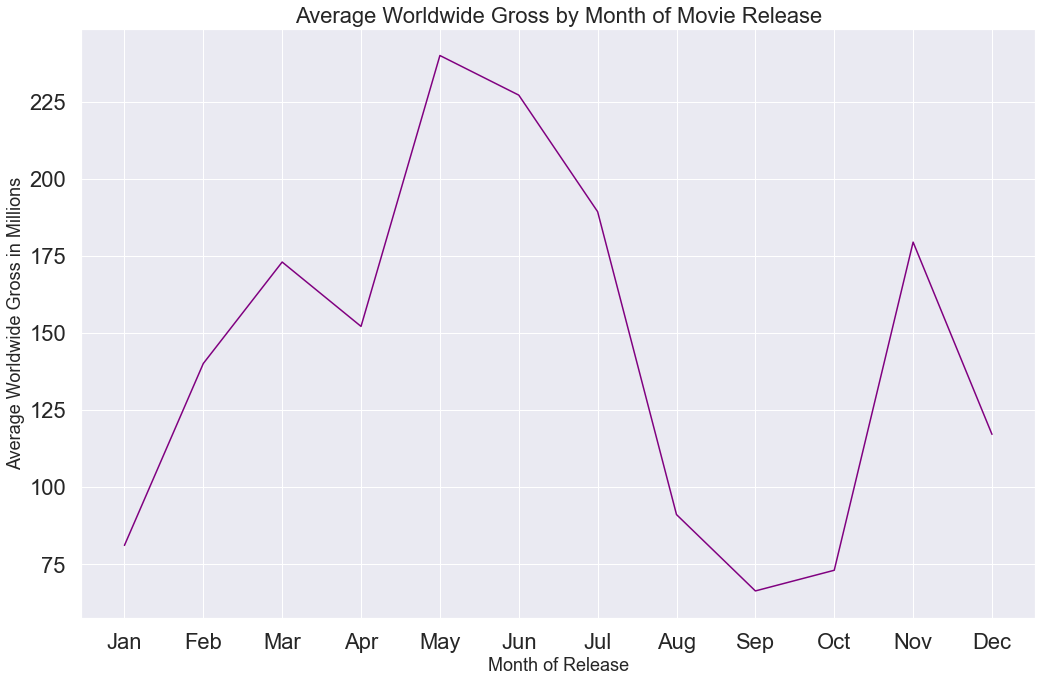

In [40]:
# Bar Plot of Ratings by Genre
fig, ax = plt.subplots(figsize=(15,10))
lplot = sns.lineplot(x = 'release_month',
            y = 'Gross (MM)',
            data = month,
            ax = ax,
            color = 'purple')
fig.tight_layout()

# set labels
plt.xlabel("Month of Release", size=18)
plt.ylabel("Average Worldwide Gross in Millions", size=18)
plt.title("Average Worldwide Gross by Month of Movie Release", size=22)

plt.tight_layout()

Movies released in late spring to early summer generate substantial worldwide gross, with May generating 195MM on average.
Late summer and early fall movie releases yield the lowest worldwide gross on average

## Conclusion

- Microsoft should create Animated, Adventure, or Action movies, as these genre's have the highest median profit
- 
- Microsoft should aim to release movies in early summer, as May, June, and July have the highest average movie gross. 

## Next Steps

- Kick off Microsoft’s movie studio by creating an animation film, as these tend to generate the highest profits with minimal risk of costing more than its gross earnings. Adventure and Family films also have 
- Utilizing experienced crew members in the Animation genre such as Pierre Coffin as Director, Janey Healy as Producer, and Michael Giacchino as composer will yield successful films.
- Microsoft should avoid delaying movie releases to late summer and fall seasons and should prioritize releasing films in May, June, or July, as viewers are more likely to hit the movie theatre then.